<a href="https://colab.research.google.com/github/kjg331/Analyze_Korean_comment/blob/main/Hoyoverse_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 댓글 스크랩

In [ ]:
# 이 부분은 처음 한번만 실행하면 됌.
# 코드 수정 - "The reason is that the last Ubuntu update update supports chromium driver just via snap."
# 최근 우분투 업데이트에서 크롬 드라이버 설치를 snap을 이용해서만 하도록 바뀜
# 고로 snap 없이 설치하는 아래 우회 코드로 변경
# 출처 : https://colab.research.google.com/drive/1cbEvuZOhkouYLda3RqiwtbM-o9hxGLyC
# 출처2 : https://stackoverflow.com/questions/75155063/selenium-use-chrome-on-colab-got-unexpectedly-exited

%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium

Executing: /tmp/apt-key-gpghome.fgcEKSu44g/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: public key "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.IU6GslGZrp/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: public key "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.U65DuI77Tj/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: public key "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 http://deb.debian.org/debian bust

In [ ]:
import requests
import re
import time
import os
import pandas as pd
import json
import sys
import warnings
warnings.filterwarnings(action='ignore')
from bs4 import BeautifulSoup

# -*- coding: UTF-8 -*-
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By

#Colab에선 웹브라우저 창이 뜨지 않으므로 별도 설정한다.

s = Service(r'/usr/bin/chromedriver')
options = webdriver.ChromeOptions()
options.add_argument('--headless')        # Head-less 설정
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--disable-blink-features=AutomationControlled')
driver = webdriver.Chrome(service = s, options=options)

In [ ]:
def get_page_sources_youtube(url):

    driver = webdriver.Chrome(service = s, options=options)
    browser = driver
    page_sources = []

    # Move to the page
    url = url
    browser.get(url)

    # Scroll down
    last_page_height = browser.execute_script("return document.documentElement.scrollHeight")

    # Iterate until end script of the website
    while True:

        browser.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
        time.sleep(3.0)

        new_page_height = browser.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")

        if new_page_height == last_page_height:

            break

        else:
            print("Continue")

        last_page_height = new_page_height

        print("End of scrolling")

        page_source = browser.page_source
        page_sources.append(page_source)

    return page_sources

In [ ]:
def get_info(url):

    url = url
    headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36 Edg/117.0.2045.36"}
    res = requests.get(url, headers=headers)
    res.raise_for_status()
    soup = BeautifulSoup(res.text, "lxml")

    info = []

    video_name = soup.find('meta', itemprop="name")['content']
    num_views = soup.find('meta', itemprop="interactionCount")['content']
    date_published = soup.find('meta', itemprop="datePublished")['content']

    info.append([video_name, num_views, date_published])

    video_info = pd.DataFrame(index = ["Info"], columns = ['Video_name', 'Num_views', 'Date_published'],
                              data = info).transpose()
    return video_info

def get_Comment_Like(url):

    driver = webdriver.Chrome(service = s, options=options)
    browser = driver
    comment = []
    comment_date= []
    num_like = []

    # Move to the page
    url = url
    browser.get(url)

    # Scroll down and wait to get the reply

    browser.execute_script("window.scrollTo(0, 800);")
    time.sleep(10)
    browser.execute_script("window.scrollTo(800, 0);")
    time.sleep(5)
    browser.execute_script("window.scrollTo(10, document.documentElement.scrollHeight);")
    time.sleep(5)

    last_page_height = browser.execute_script("return document.documentElement.scrollHeight")

    # Iterate until end script of the website
    while True:

        browser.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
        time.sleep(3.0)

        new_page_height = browser.execute_script("return document.documentElement.scrollHeight")

        if new_page_height == last_page_height:
            print("End scrolling")
            print("---"*30)
            print("Start Scrapping")
            break

        else:
            print("Iterating...")

        last_page_height = new_page_height

    # Get the comment
    for comments in browser.find_elements(By.ID, "content-text"):
        comment.append(comments.text)

    # Get year of the comment("~months,weeks,days" will be 2022 and others will be "2022 - ~years" in this code)
    for dates in browser.find_elements(By.XPATH, '//*[@id="header-author"]/yt-formatted-string/a'):
        comment_date.append(dates.text)

    # Get the num of likes
    for likes in browser.find_elements(By.ID, "vote-count-middle"):

        if likes.text:
            num_like.append(likes.text)
        else:
            num_like.append("0")



    browser.quit()
    # Make the dataframe with scrapped data
    video_content = pd.DataFrame({"Comment": comment, "Comment_date": comment_date, "Likes": num_like})
    video_content.Comment_date = video_content.Comment_date.apply(change_year)
    video_content.Likes = video_content.Likes.apply(convert_str_to_number)

    return video_content

def convert_str_to_number(x):

    total_stars = 0
    num_map = {'천': 1000, '만': 10000, 'K':1000, 'M':1000000, 'B':1000000000}

    if x.isdigit():
        total_stars = int(x)
    else:
        if len(x) > 1:
            total_stars = float(x[:-1]) * num_map.get(x[-1].upper(), 1)

    return int(total_stars)

def change_year(w):
    w = w.strip()
    w = re.sub(r"\(수정됨\)", " ", w)
    w = re.sub(r"전", " ", w)
    w = re.sub(r"1년", "2022", w)
    w = re.sub(r"2년", "2021", w)
    w = re.sub(r"3년", "2020", w)
    w = w.strip()
    w = re.sub("([0-9]+)([^0-9]+$)", "2023", w) # Change any other period to 2023
    return w

In [ ]:
url = "https://www.youtube.com/watch?v=MQ4Fu5vRXjM&t=38s&ab_channel=%EC%9B%90%EC%8B%A0"
test_info = get_info(url)
test_df = get_Comment_Like(url)

KeyboardInterrupt: ignored

In [ ]:
genshin_2023_df

,Comment,Comment_date,Likes,video
0,진짜 이렇게 잘 챙겨주는 게임사 어디있나. 심지어 자국도 아닌데 ㅋㅋㅋ \n중간에 ...,2023,223,원신 | 2023 여름 축제 리뷰 영상
1,중간에 불미스러운 일이 있었음에도 불구하고 최선을 다해주신 \n호요버스 코리아와 참...,2023,343,원신 | 2023 여름 축제 리뷰 영상
2,운영진분들이 정말 열심히 준비했다는 게 느껴지는 축제였습니다..! 코스어분들이랑 사...,2023,73,원신 | 2023 여름 축제 리뷰 영상
3,이번 원신축제는 정말 제 인생 최고의 날이였습니다. 하루종일 다리 아픈줄도 모르고 ...,2023,27,원신 | 2023 여름 축제 리뷰 영상
4,무더운 날씨였지만 구경거리도 많고 즐거운 행사였어요!! 작년에 비해 규모도 훨씬 커...,2023,36,원신 | 2023 여름 축제 리뷰 영상
...,...,...,...,...
121,可愛さがあふれる。韓国語勉強しないと。,2023,0,2023-08-01
122,랑자하신분 여성분인가요?,2023,0,2023-08-01
123,이분 혹시 돔 안에서 눕방하시던 분이신가?,2023,0,2023-08-01
124,댱이는 신이야,2023,0,2023-08-01


In [ ]:
genshin_2023_info

,Info,num_comments
Video_name,원신 | 2023 여름 축제 리뷰 영상,179
Num_views,39356,179
Date_published,2023-08-11,179
Video_name,아 ㅋㅋㅋ 여기 왔다가 딱걸림 ㅋㅋㅋ 원신 여름축제 같이 한번 보쉴? [원신 202...,22
Num_views,5175,22
Date_published,2023-07-26,22
Video_name,전부 다 보여줄게! [2023 원신 여름 축제],126
Num_views,43411,126
Date_published,2023-08-01,126


In [ ]:
#원신 2023 여름축제 기반으로 데이터 생성

In [ ]:
urls = ["https://www.youtube.com/watch?v=MQ4Fu5vRXjM&t=38s&ab_channel=%EC%9B%90%EC%8B%A0",
       "https://www.youtube.com/watch?v=Mp99Fyd0R8M&ab_channel=%EB%B9%84%EB%88%84TV",
        "https://www.youtube.com/watch?v=bdAYfJN0oQM&ab_channel=%EB%8C%B1%EC%9D%B4DyangYi",
        "https://www.youtube.com/watch?v=o3tqnnSzpdk&ab_channel=New%EC%B9%98%ED%82%A8%EB%9C%AF%EB%8A%94%EC%97%AC%EC%9A%B0",
        "https://www.youtube.com/watch?v=MJ431OoCvNs&ab_channel=M%EB%93%9C%EB%A1%9C%EB%A9%94%EB%8B%A4%EC%8A%A4%ED%8A%9C%EB%94%94%EC%98%A4",
        "https://www.youtube.com/watch?v=9iD9V6mdFVQ&t=10s&ab_channel=%ED%8F%AC%EB%A7%88%EB%8B%88%EC%95%84-Pomania",
        "https://www.youtube.com/watch?v=ILuVY4hQoqg&ab_channel=%ED%98%9C%EC%9C%B0",
        "https://www.youtube.com/watch?v=2-tB8DfuReM&t=3s&ab_channel=%EC%8A%A4%EB%B8%8C%EC%8A%A4%EB%89%B4%EC%8A%A4SUBUSUNEWS",
        "https://www.youtube.com/watch?v=64mYX-lscrI&ab_channel=%EC%83%98%EC%9B%A8",
        "https://www.youtube.com/watch?v=e2FzcCbJbmg&ab_channel=%EA%B4%80%EC%A2%85%EB%8C%80%EC%99%95",
        "https://www.youtube.com/watch?v=7stAk63MpTA&ab_channel=%EC%95%84%EB%A7%81%EB%8B%AC%EB%A7%81%ED%96%A5%ED%8C%8C%EB%A7%81"]

In [ ]:
genshin_2023_info = get_info(urls[0])
genshin_2023_df = get_Comment_Like(urls[0])
genshin_2023_info["num_comments"] = len(genshin_2023_df)

for i in range(1, len(urls)):
    new_info = get_info(urls[i])
    new_df = get_Comment_Like(urls[i])

    new_info["num_comments"] = len(new_df)

    genshin_2023_info = pd.concat([genshin_2023_info, new_info])
    genshin_2023_df = pd.concat([genshin_2023_df, new_df])

genshin_2023_df.reset_index(drop = True, inplace = True)
genshin_2023_df

Iterating...
Iterating...
Iterating...
Iterating...
Iterating...
Iterating...
Iterating...
Iterating...
End scrolling
------------------------------------------------------------------------------------------
Start Scrapping
Iterating...
End scrolling
------------------------------------------------------------------------------------------
Start Scrapping
Iterating...
Iterating...
Iterating...
Iterating...
Iterating...
Iterating...
End scrolling
------------------------------------------------------------------------------------------
Start Scrapping
Iterating...
Iterating...
End scrolling
------------------------------------------------------------------------------------------
Start Scrapping
Iterating...
Iterating...
Iterating...
Iterating...
Iterating...
End scrolling
------------------------------------------------------------------------------------------
Start Scrapping
End scrolling
------------------------------------------------------------------------------------------
Star

,Comment,Comment_date,Likes
0,진짜 이렇게 잘 챙겨주는 게임사 어디있나. 심지어 자국도 아닌데 ㅋㅋㅋ \n중간에 ...,2023,223
1,중간에 불미스러운 일이 있었음에도 불구하고 최선을 다해주신 \n호요버스 코리아와 참...,2023,343
2,운영진분들이 정말 열심히 준비했다는 게 느껴지는 축제였습니다..! 코스어분들이랑 사...,2023,73
3,이번 원신축제는 정말 제 인생 최고의 날이였습니다. 하루종일 다리 아픈줄도 모르고 ...,2023,27
4,무더운 날씨였지만 구경거리도 많고 즐거운 행사였어요!! 작년에 비해 규모도 훨씬 커...,2023,36
...,...,...,...
860,오랜만에 영상이다!!!\n첫 얼굴 나오는 장면에서 벌써 지쳐 보입니다,2023,1
861,아링아링은 방랑 때매 죽는데\n나는 귀여운 아링아링 때매 죽게생겼네\n사랑해 아링짱,2023,1
862,엇...얼굴 안 가려도 되셧는데요ㅎㅎ \n어차피 코스어활동할꺼라서 방송에서 얼굴 공...,2023,1
863,b타임이였는데 밖에 비많이 오고 너무 습했어요,2023,1


In [ ]:
genshin_2023_info

,Info,num_comments
Video_name,원신 | 2023 여름 축제 리뷰 영상,179
Num_views,39349,179
Date_published,2023-08-11,179
Video_name,아 ㅋㅋㅋ 여기 왔다가 딱걸림 ㅋㅋㅋ 원신 여름축제 같이 한번 보쉴? [원신 202...,20
Num_views,5175,20
Date_published,2023-07-26,20
Video_name,전부 다 보여줄게! [2023 원신 여름 축제],22
Num_views,43411,22
Date_published,2023-08-01,22
Video_name,"2023 원신 여름축제 재밌게 즐기고 왔습니다! (몇가지 팁,느낀 점들)",126


In [ ]:
genshin_2023_df

,Comment,Comment_date,Likes
0,진짜 이렇게 잘 챙겨주는 게임사 어디있나. 심지어 자국도 아닌데 ㅋㅋㅋ \n중간에 ...,2023,223
1,중간에 불미스러운 일이 있었음에도 불구하고 최선을 다해주신 \n호요버스 코리아와 참...,2023,343
2,운영진분들이 정말 열심히 준비했다는 게 느껴지는 축제였습니다..! 코스어분들이랑 사...,2023,73
3,이번 원신축제는 정말 제 인생 최고의 날이였습니다. 하루종일 다리 아픈줄도 모르고 ...,2023,27
4,무더운 날씨였지만 구경거리도 많고 즐거운 행사였어요!! 작년에 비해 규모도 훨씬 커...,2023,36
...,...,...,...
860,오랜만에 영상이다!!!\n첫 얼굴 나오는 장면에서 벌써 지쳐 보입니다,2023,1
861,아링아링은 방랑 때매 죽는데\n나는 귀여운 아링아링 때매 죽게생겼네\n사랑해 아링짱,2023,1
862,엇...얼굴 안 가려도 되셧는데요ㅎㅎ \n어차피 코스어활동할꺼라서 방송에서 얼굴 공...,2023,1
863,b타임이였는데 밖에 비많이 오고 너무 습했어요,2023,1


# 2. 단어 벡터화 하기

In [ ]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 22.8 MB/s eta 0:00:00


In [ ]:
import re
import requests
import string
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
import seaborn as sns
from collections import Counter

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

# 한글 표시
import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt

from konlpy.tag import Okt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

In [ ]:
# Stop WOrds 정리

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('한국어 불용어').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
print(rows)

# Convert to a DataFrame and render.
import pandas as pd
stop_words = pd.DataFrame.from_records(rows)
stop_words = stop_words.iloc[:, 0].to_list()
more_words = ["너무", "진짜"]

stop_words = stop_words + more_words

[['가'], ['가까스로'], ['가령'], ['각'], ['각각'], ['각자'], ['각종'], ['갖고말하자면'], ['같다'], ['같이'], ['개의치않고'], ['거니와'], ['거바'], ['거의'], ['것'], ['것과 같이'], ['것들'], ['게다가'], ['게우다'], ['겨우'], ['견지에서'], ['결과에 이르다'], ['결국'], ['결론을 낼 수 있다'], ['겸사겸사'], ['고려하면'], ['고로'], ['곧'], ['공동으로'], ['과'], ['과연'], ['관계가 있다'], ['관계없이'], ['관련이 있다'], ['관하여'], ['관한'], ['관해서는'], ['구'], ['구체적으로'], ['구토하다'], ['그'], ['그들'], ['그때'], ['그래'], ['그래도'], ['그래서'], ['그러나'], ['그러니'], ['그러니까'], ['그러면'], ['그러므로'], ['그러한즉'], ['그런 까닭에'], ['그런데'], ['그런즉'], ['그럼'], ['그럼에도 불구하고'], ['그렇게 함으로써'], ['그렇지'], ['그렇지 않다면'], ['그렇지 않으면'], ['그렇지만'], ['그렇지않으면'], ['그리고'], ['그리하여'], ['그만이다'], ['그에 따르는'], ['그위에'], ['그저'], ['그중에서'], ['그치지 않다'], ['근거로'], ['근거하여'], ['기대여'], ['기점으로'], ['기준으로'], ['기타'], ['까닭으로'], ['까악'], ['까지'], ['까지 미치다'], ['까지도'], ['꽈당'], ['끙끙'], ['끼익'], ['나'], ['나머지는'], ['남들'], ['남짓'], ['너'], ['너희'], ['너희들'], ['네'], ['넷'], ['년'], ['논하지 않다'], ['놀라다'], ['누가 알겠는가'], ['누구'], ['다른'], ['다른 방면으로'], ['다만'], ['다섯'], ['다소'], ['다수'], ['다시 말하자면'], ['다시말하면'

In [ ]:
stop_words[:5]

['가', '가까스로', '가령', '각', '각각']

In [ ]:
# Preparing for the tool
okt = Okt()

def word_extract(text):
    text = str(text)
    text = text.strip()
    text = re.sub(r"[^0-9가-힣a-zA-Z?.!,¿]+", " ", text) # \n도 공백으로 대체해줌
    text = text.strip()
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove URL
    text = re.sub(r'#', '', text) #Change hashtag text to normal text
    text = re.sub(r'^@', '', text) #Remove user-mention text
    text_pos = okt.pos(text, norm=True, stem=True, join=False)
    check_list = ["Verb","Noun","Adjective",'Foreign','Adverb'] # 동사, 명사, 형용사, 부사, 외국어, 부사
    list = [c for c,tag in text_pos if tag in check_list]
    word = [i.split('/')[0] for i in list]
    word = [x for x in word if x not in stop_words]
    return (" ".join(word))

In [ ]:
text = """진짜 이렇게 잘 챙겨주는 게임사 어디있나. 심지어 자국도 아닌데 ㅋㅋㅋ
중간에 불미스런일이 있었지만 별탈없었고 또 대처도 너무 잘해주심.
매년 이런 축제에 감사드리고 내년 폰타인배경의 축제도 너무 기대됨용
여름축제에 운영진, 참가자 모두 고생많으셨습니다"""
text_list = word_extract(text)
text_list

'진짜 이렇게 자다 챙기다 게임 자국 아니다 중간 불미 일이 별탈 없다 대처 너무 하다 주심 매년 이렇다 축제 감사 드리다 내년 폰 배경 축제 너무 기대 되다 여름 축제 운영 진 참가자 고생 많다'

In [ ]:
#원신 여름축제 2023 유튜브 댓글 단어 추출

genshin_2023_df["cleaned_comment"] = genshin_2023_df["Comment"].apply(word_extract)

In [ ]:
genshin_2023_df

,Comment,Comment_date,Likes,cleaned_comment
0,진짜 이렇게 잘 챙겨주는 게임사 어디있나. 심지어 자국도 아닌데 ㅋㅋㅋ \n중간에 ...,2023,223,이렇게 자다 챙기다 게임 자국 아니다 중간 불미 일이 별탈 없다 대처 하다 주심 매...
1,중간에 불미스러운 일이 있었음에도 불구하고 최선을 다해주신 \n호요버스 코리아와 참...,2023,343,중간 불미 불구 최선 다해 주신 호 버스 코리아 참여 해주다 모든 분 감사 표 하다
2,운영진분들이 정말 열심히 준비했다는 게 느껴지는 축제였습니다..! 코스어분들이랑 사...,2023,73,운영 진 정말 열심히 준비 하다 게 느껴지다 축제 이다 코스 어분 사진 찍다 슬러쉬...
3,이번 원신축제는 정말 제 인생 최고의 날이였습니다. 하루종일 다리 아픈줄도 모르고 ...,2023,27,축제 정말 인생 최고 날다 하루 종일 다리 아프다 모르다 싱글벙글 웃다 다니다 축제...
4,무더운 날씨였지만 구경거리도 많고 즐거운 행사였어요!! 작년에 비해 규모도 훨씬 커...,2023,36,무덥다 날씨 이다 거리 많다 즐겁다 행사 이다 작년 비다 규모 커지다 스탭 많이 신...
...,...,...,...,...
860,오랜만에 영상이다!!!\n첫 얼굴 나오는 장면에서 벌써 지쳐 보입니다,2023,1,만 영상 첫 얼굴 나오다 장면 벌써 지치다 보이다
861,아링아링은 방랑 때매 죽는데\n나는 귀여운 아링아링 때매 죽게생겼네\n사랑해 아링짱,2023,1,링 링 방랑 때매 죽다 귀엽다 링 링 때매 죽다 생기다 사랑 하다 링
862,엇...얼굴 안 가려도 되셧는데요ㅎㅎ \n어차피 코스어활동할꺼라서 방송에서 얼굴 공...,2023,1,얼굴 안 가다 되셧는데 어차피 코스 활동 하다 방송 얼굴 공개 하다 하다
863,b타임이였는데 밖에 비많이 오고 너무 습했어요,2023,1,타임 이다 비 많이 오다 습하다


In [ ]:
# Vectorizer

tfid = TfidfVectorizer(ngram_range=(2, 2)) # 2그램 ~ 3그램으로 분리
tfid_fit = tfid.fit_transform(genshin_2023_df["cleaned_comment"])

In [ ]:
# TF-IDF score table(2gram)
tfid_vec = tfid.transform(genshin_2023_df["cleaned_comment"])
word_list = tfid.get_feature_names_out()
count_list = tfid_vec.toarray().sum(axis=0)
tfidf_score_df = pd.DataFrame(count_list, word_list).sort_values(by = [0], ascending = False)
tfidf_score_df.columns = ["tf_idf_score"]
tfidf_score_df

,tf_idf_score
여름 축제,7.771612
사진 찍다,6.157521
고생 하다,5.574975
코스프레 하다,4.477918
폭탄 테러,4.371517
...,...
들다 너무,0.000000
최고다 너무,0.000000
들어가다 너무,0.000000
들어가다 진짜,0.000000


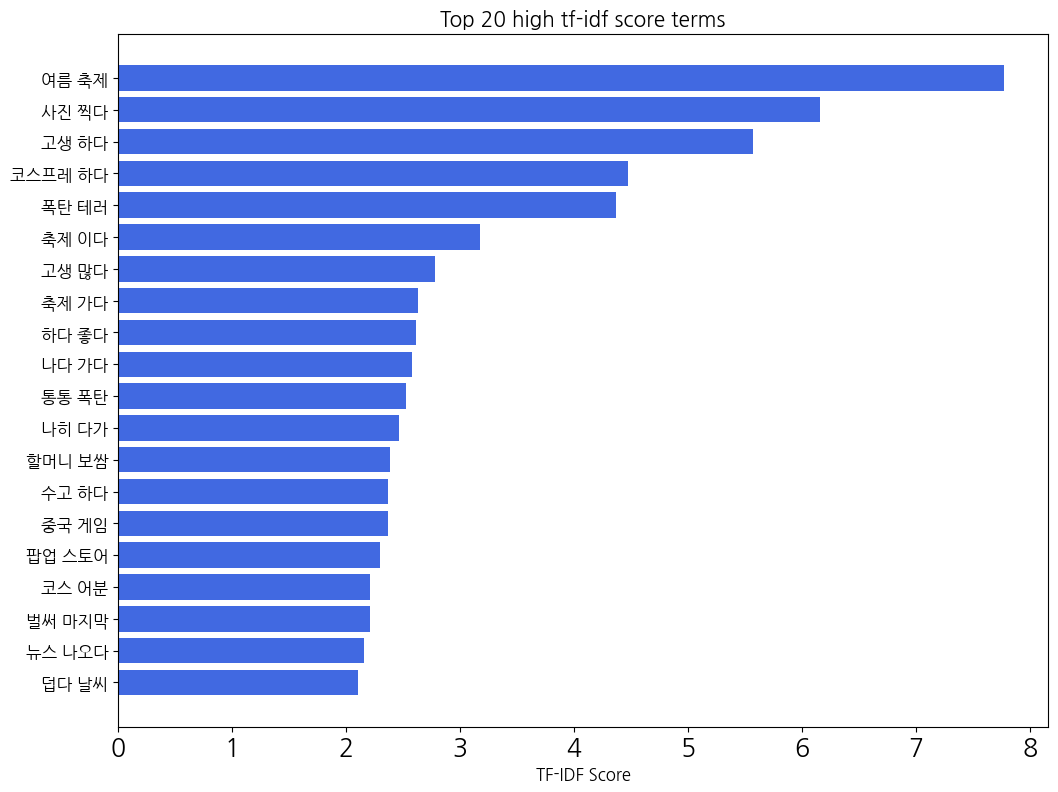

In [ ]:
top_20 = tfidf_score_df["tf_idf_score"][:20].sort_values(ascending = True)
y_pos = np.arange(len(top_20)).astype(int)
plt.figure(figsize=(12, 9))
plt.barh(y_pos, top_20, align='center', alpha = 1, color = "royalblue")
#plt.xticks(y_pos, rotation=90, size = 15)
plt.yticks(y_pos, labels = top_20.index, size = 12)
#plt.ylabel('Terms', size = 12)
plt.xlabel('TF-IDF Score', size = 12)
plt.title('Top 20 high tf-idf score terms', size = 15)
plt.show()
#plt.savefig('Top 20 high tf-idf score terms.png', bbox_inches='tight')

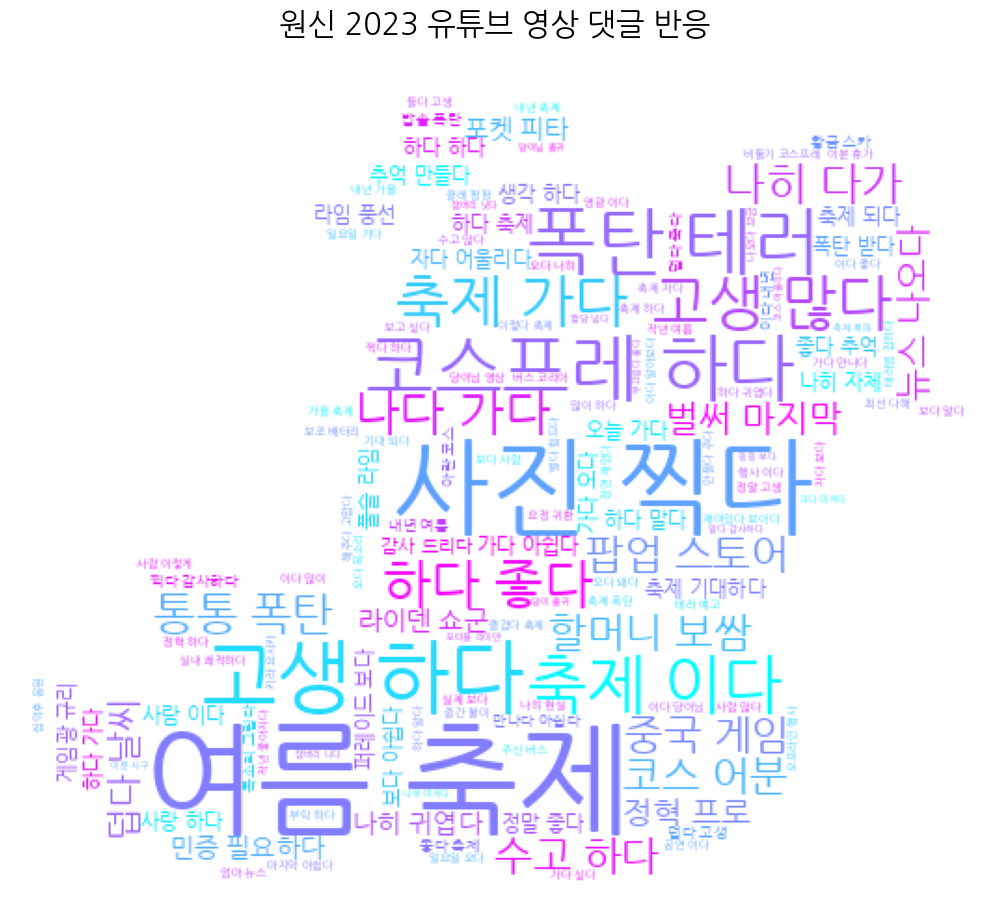

In [ ]:
# Tf-Idf Worldcoud
wc = WordCloud(font_path='NanumGothic',
               background_color='white',
                max_words=200,
                width=1350, height=900,
               stopwords = stopwords,
               colormap='cool_r',
               mask = mask)
wc.generate_from_frequencies(tfidf_score_df['tf_idf_score'])
plt.figure(figsize=(13.5,9))
plt.title('원신 2023 유튜브 영상 댓글 반응',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()
#plt.savefig('wordcloud_tf_idf.png', bbox_inches='tight')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/김진구 개인/vvvvv.jpg"
mask = np.array(Image.open(path))
mask

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]